In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.metrics import classification_report , confusion_matrix
import itertools
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from utils import *
from grad_cam import *
import io
from PIL import Image as PILImage
import random
from pytorch_grad_cam import run_dff_on_image, GradCAM, ScoreCAM


In [2]:
def apply_train_transforms(image):
    train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return train_transform(image)

In [3]:
def apply_test_valid_transforms(image):
    val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return val_test_transform(image)

In [4]:
def train_collate_fn(batch):
    transformed_images = []
    labels = []
    for image, label in batch:
        transformed_image = apply_train_transforms(image)
        transformed_images.append(transformed_image)
        labels.append(label)
    return torch.stack(transformed_images), torch.tensor(labels)

In [5]:
def test_valid_collate_fn(batch):
    transformed_images = []
    labels = []
    for image, label in batch:
        transformed_image = apply_test_valid_transforms(image)
        transformed_images.append(transformed_image)
        labels.append(label)
    return torch.stack(transformed_images), torch.tensor(labels)

In [6]:
data_dir = "C:/Users/Jan/SGH/magisterka/dane/brain_tumor_mri_cropped-10"

### Transformacje dla poszczególnych zbiorów

In [7]:
ds = datasets.ImageFolder(data_dir)

In [8]:
class_names = ds.classes
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [9]:
custom_labels = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [10]:
train_size = int(0.8 * len(ds))
valid_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(ds, [train_size, valid_size, test_size])

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_valid_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_valid_collate_fn)

### Ładowanie pre-wytrenowanego modelu

In [12]:
# Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(ds.classes))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Definiowanie funkcji straty oraz optymizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=len(train_loader) * 20)

In [14]:
num_epochs = 50

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [16]:
model, model_history = train_and_validate(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device, "C:/Users/Jan/SGH/magisterka/repo/praca_magisterska/ViT_hugging_face/", "vit-pytorch-mri-full-best-model.pth")

Najlepszy model został zapisany do C:/Users/Jan/SGH/magisterka/repo/praca_magisterska/ViT_hugging_face/vit-pytorch-mri-full-best-model.pth
Epoch [1/50] Train Loss: 1.1991, Train Accuracy: 55.36% Val Loss: 1.0414, Val Accuracy: 61.43% Czas trwania epoki: 15.73s
Najlepszy model został zapisany do C:/Users/Jan/SGH/magisterka/repo/praca_magisterska/ViT_hugging_face/vit-pytorch-mri-full-best-model.pth
Epoch [2/50] Train Loss: 0.8698, Train Accuracy: 74.11% Val Loss: 0.7448, Val Accuracy: 75.71% Czas trwania epoki: 7.32s
Najlepszy model został zapisany do C:/Users/Jan/SGH/magisterka/repo/praca_magisterska/ViT_hugging_face/vit-pytorch-mri-full-best-model.pth
Epoch [3/50] Train Loss: 0.6803, Train Accuracy: 78.93% Val Loss: 0.5700, Val Accuracy: 82.86% Czas trwania epoki: 7.22s
Najlepszy model został zapisany do C:/Users/Jan/SGH/magisterka/repo/praca_magisterska/ViT_hugging_face/vit-pytorch-mri-full-best-model.pth
Epoch [4/50] Train Loss: 0.5494, Train Accuracy: 83.93% Val Loss: 0.4086, Val Ac

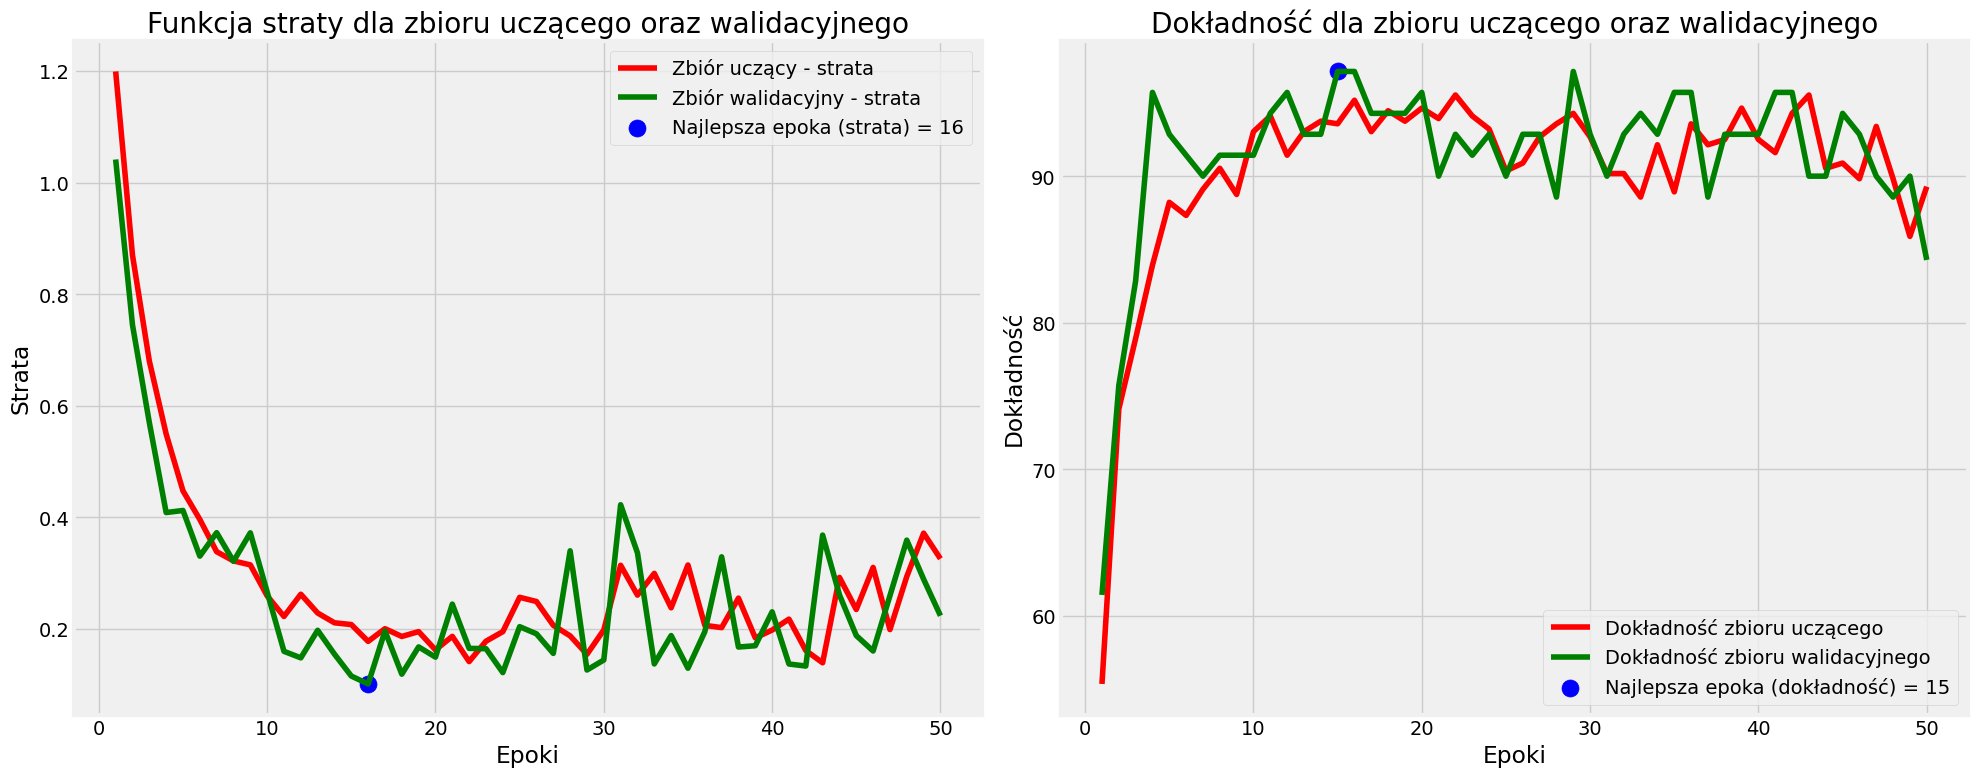

In [17]:
show_loss_accuracy_plots(model_history)

### Testowanie modelu

In [18]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 81.69%


In [19]:
evaluate_model(model, test_loader, device)

              precision    recall  f1-score   support

      glioma       1.00      0.43      0.60        14
  meningioma       0.80      0.62      0.70        13
     notumor       1.00      1.00      1.00        21
   pituitary       0.68      1.00      0.81        23

    accuracy                           0.82        71
   macro avg       0.87      0.76      0.78        71
weighted avg       0.86      0.82      0.80        71



In [20]:
test_predictions, test_labels = get_predictions_and_labels(model, test_loader, device)

In [21]:
cm_test = confusion_matrix(test_labels, test_predictions)

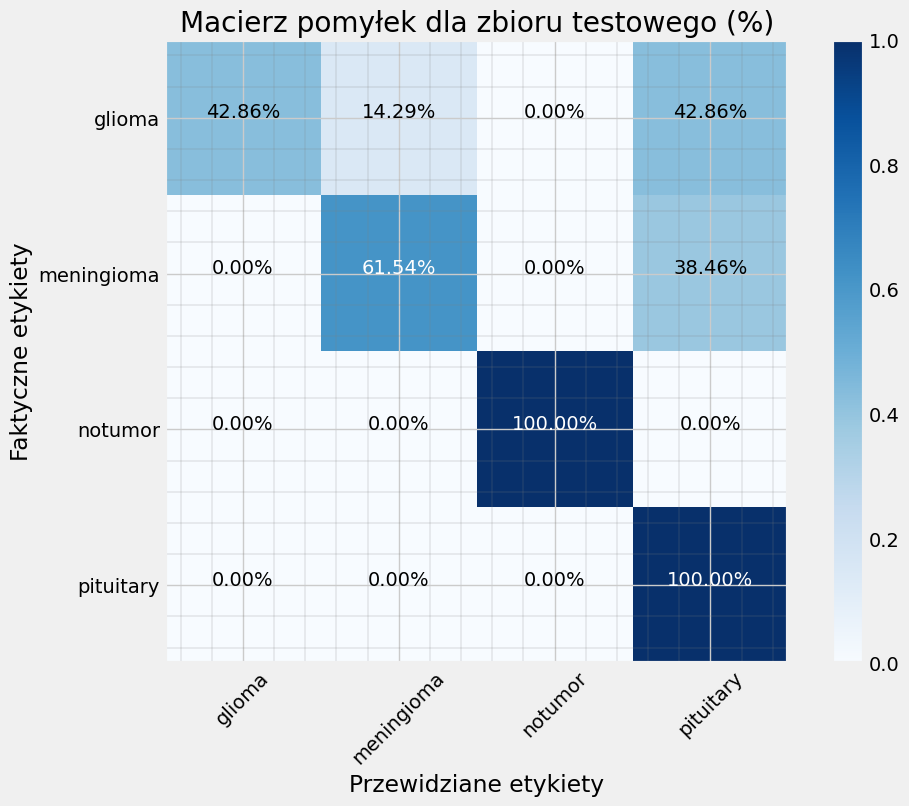

In [22]:
plot_confusion_matrix_percent(cm_test, class_names, 'Macierz pomyłek dla zbioru testowego (%)')

Label: glioma


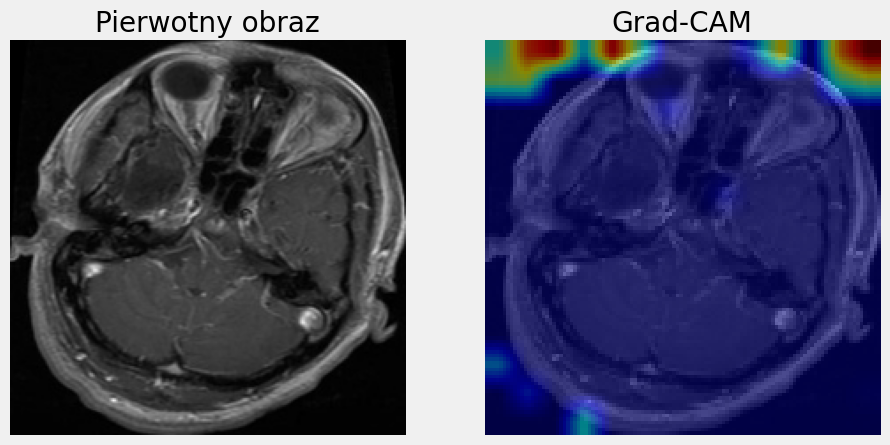

Label: meningioma


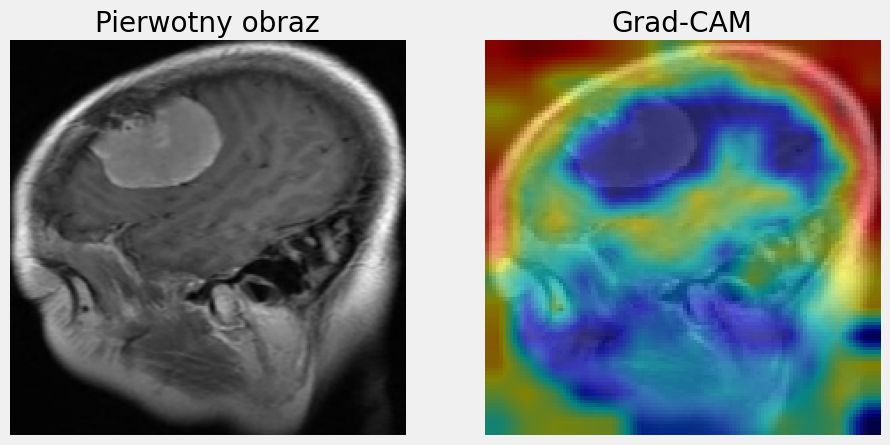

Label: notumor


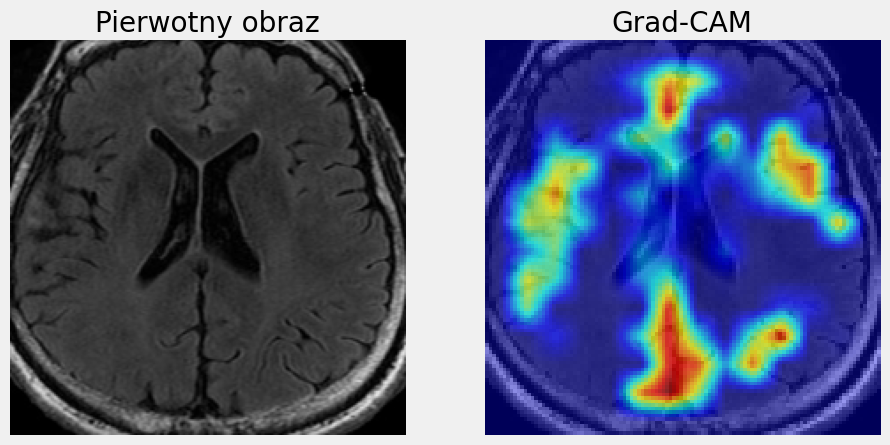

Label: pituitary


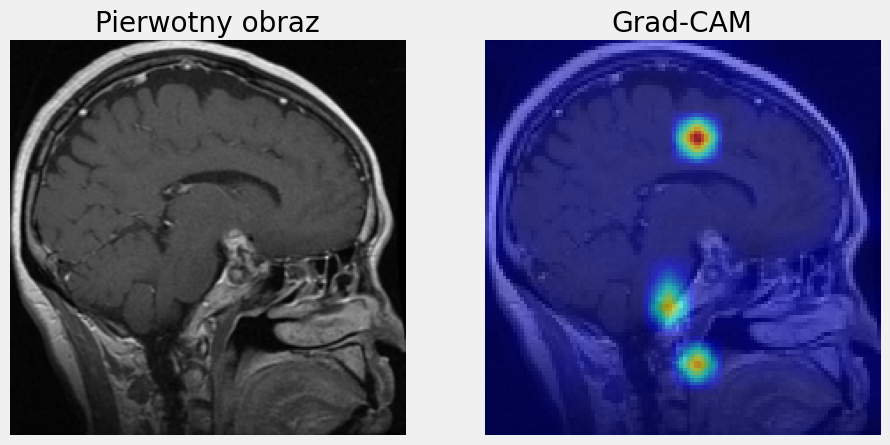

In [23]:
display_images_with_gradcam(model=model, dataset = train_dataset, reshape_transform = reshape_transform_vit_huggingface, custom_labels = custom_labels, num_classes = len(class_names), method=GradCAM, method_name="Grad-CAM")

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 12.34it/s]


Label: glioma


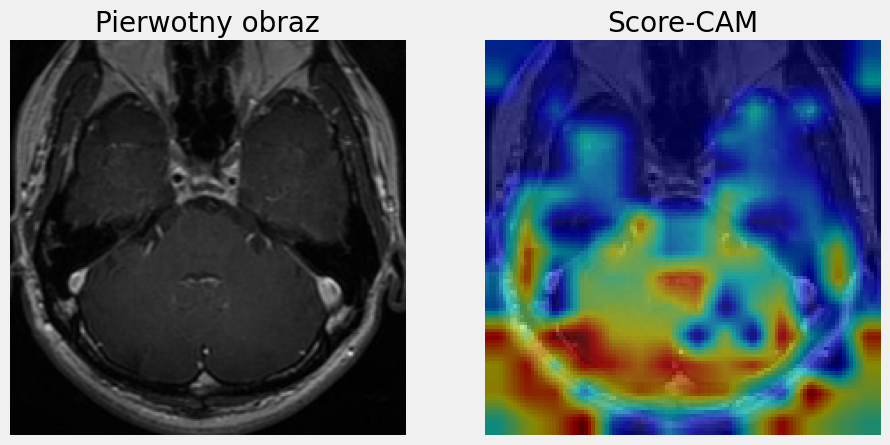

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.17it/s]


Label: meningioma


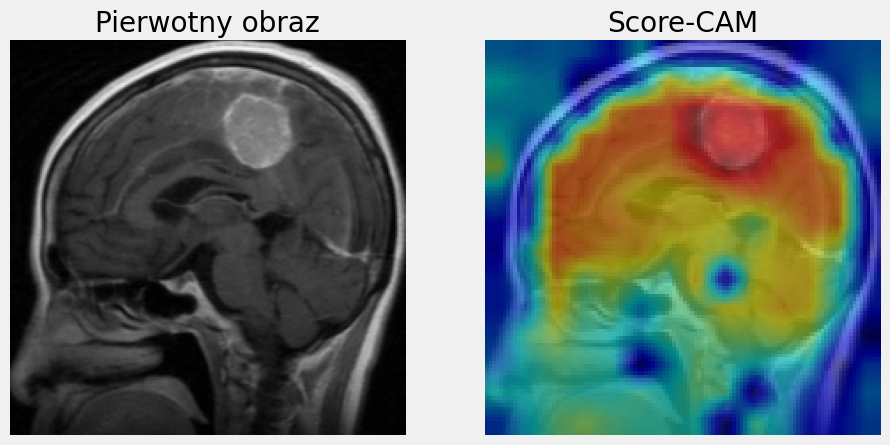

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.12it/s]


Label: notumor


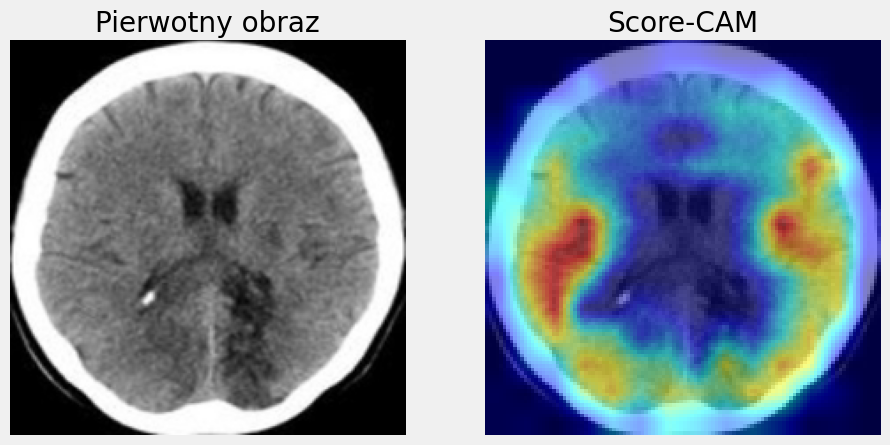

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.17it/s]


Label: pituitary


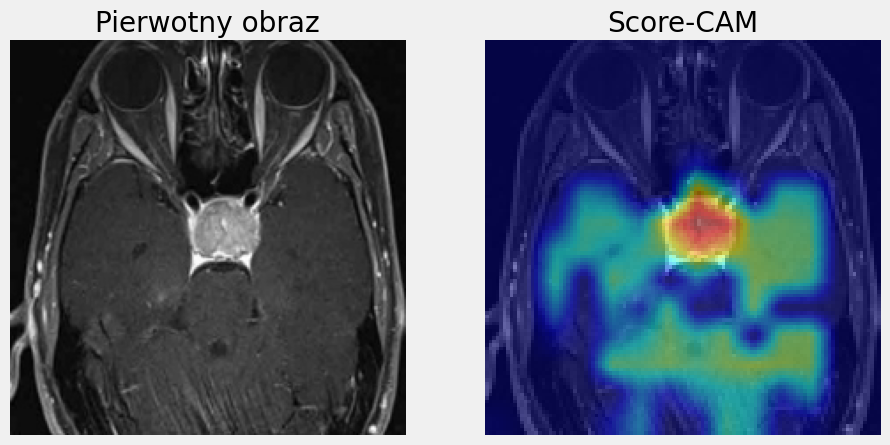

In [24]:
display_images_with_gradcam(model=model, dataset = train_dataset, reshape_transform = reshape_transform_vit_huggingface, custom_labels = custom_labels, num_classes = len(class_names), method=ScoreCAM, method_name="Score-CAM")